In [1]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import torch

# 创建数据库引擎
database_url = "sqlite:///../data/data.sqlite"
engine = create_engine(database_url)

# define hyper paras
use_standard_scaler = True
save_imputed_data = False
notebook_mode = 'train'
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

model_name = 'TransformerLSTM'
saved_table = 'sh_customs_daily_pred'
version = '0.5.0'

In [2]:
def plot_time_series(df, title='Time Series Data', xlabel='Date', ylabel='Value', figsize=(10, 6)):
    """
    绘制一个或多个时序数据的函数。
    
    参数:
    - df: 一个pandas DataFrame，索引为日期时间类型，每一列是一个时间序列。
    - title: 图表的标题。
    - xlabel: x轴的标签。
    - ylabel: y轴的标签。
    - figsize: 图表的尺寸，以英寸为单位。
    """
    plt.figure(figsize=figsize)
    for column in df.columns:
        plt.plot(df.index, df[column], label=column)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()


query = "select global_entry,hkmo_entry,tw_entry from sh_customs_daily_imputed"
data = pd.read_sql_query(query, engine).astype('float')
original_data = data.copy()

Data Minmax Scaler

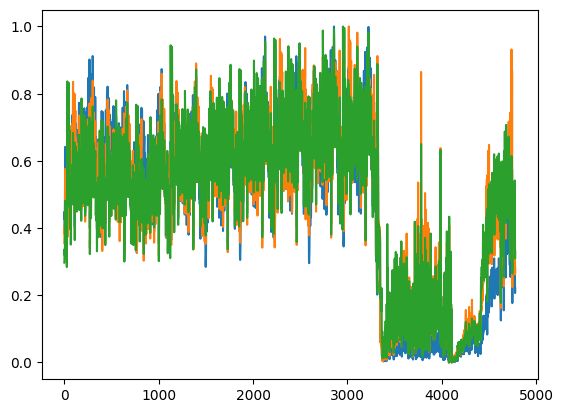

In [3]:
from sklearn.preprocessing import MinMaxScaler

scalers = {}

for column in data.columns:
    if column not in ['date']:
        scaler = MinMaxScaler()
        data[column] = scaler.fit_transform(data[column].values.reshape(-1, 1)).reshape(
            -1)
        scalers[column] = scaler

plt.plot(data)
plt.show()

In [11]:
from pygrinder import mcar
from pygrinder.utils import fill_and_get_mask_numpy, calc_missing_rate

import numpy as np

horizon = 365

X = np.concatenate([data.values, np.full((horizon, data.shape[1]), np.nan)], axis=0)  # drop date column
X = np.array([X])  # 等效unsqueeze 0 操作
missing_mask = np.isnan(X)  # keep X_ori for validation

X = mcar(X, 0.1)  # randomly hold out 10% observed values as ground truth
holding_mask = (np.isnan(X)) ^ missing_mask
print(calc_missing_rate(X))

X = np.nan_to_num(X, nan=0)

0.161353032659409


# train the model (using TSAI sklearn like API)

In [12]:
from torch import Tensor
import torch
import torch.nn as nn
from fastai.metrics import rmse, msle, AccumMetric


class MaskedMAELoss(nn.Module):
    def __init__(self):
        super(MaskedMAELoss, self).__init__()

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        # 确保输入、目标和掩码有相同的维度
        target = target.reshape(-1, input.shape[1])
        mask = holding_mask.reshape(-1, input.shape[1])
        assert input.shape == target.shape, f"Input:{input.shape}, target:{target.shape}, must have the same shape"

        # 使用掩码筛选感兴趣的元素
        filtered_inp = input[mask]
        filtered_targ = target[mask]

        # 计算L1 Loss
        l1_loss = torch.mean(torch.abs(filtered_inp - filtered_targ))

        return l1_loss


def _rmse(inp, targ):
    targ = targ.reshape(-1, inp.shape[1])
    return torch.sqrt(torch.nn.functional.mse_loss(inp[holding_mask], targ[holding_mask]))


masked_rmse = AccumMetric(_rmse, flatten=False, name='masked_rmse')

In [24]:
from tsai.models.PatchTST import PatchTST
from tsai.data.core import TSForecasting
from tsai.tslearner import TSForecaster
from tsai.callback.core import ShowGraphCallback2
from fastai.losses import MSELossFlat, L1LossFlat
from tsai.models.TransformerRNNPlus import TransformerLSTMPlus
import torch.nn

model = PatchTST(
    c_in=data.shape[0]+horizon,
    c_out=X.shape[0] * X.shape[1] * X.shape[2],
    seq_len=X.shape[1],
    d_ff=1024,
    n_layers=4,
    d_model=256,
    n_heads=8,
    dropout=0.05,
    kernel_size= 64,
    revin=True,  # must open
    affine=True,  # must open
    individual=False  # optionally open
)

learn = TSForecaster(
    X=X,
    y=X,
    splits=None,
    tfms=[None, [TSForecasting()]],
    arch=model,
    batch_size=2,
    shuffle_train=False,
    device=device,
    loss_func=MaskedMAELoss(),
    metrics=[_rmse], cbs=ShowGraphCallback2(),
    model_dir="../models",
)

if notebook_mode == 'train':
    learn.lr_find()

KeyboardInterrupt: 

In [ ]:
if notebook_mode == 'train':
    learn.fit_one_cycle(100, lr_max=1e-4)

In [ ]:
file_name = f"{model_name}_{saved_table}_{version}.pth"

if notebook_mode == 'train':
    torch.save(learn.model, f"../models/{file_name}", pickle_protocol=2)
    model = learn.model
    model.eval()
elif notebook_mode == 'predict':
    model = torch.load(f'../models/{file_name}', map_location=device)
    model.eval()

model

In [ ]:
p = torch.from_numpy(X).type(torch.float).to(device=device)
p_node = model(p)
p_node = p_node.cpu().detach().numpy().reshape(X.shape[1], X.shape[2]).T

In [ ]:
import numpy as np

# 单步多次预测
predict_len = 1
pred = []
val = data.values
step = val[-window_length:]
with torch.no_grad():
    for _ in range(predict_len):
        p = torch.from_numpy(step.reshape(-1, dls.vars, dls.len)).type(torch.float).to(device=device)
        p_node = model(p)
        p_node = p_node.cpu().numpy().reshape(horizon, -1)
        step = np.append(step, p_node, axis=0)
        step = step[horizon:, :]
        pred.append(p_node)

pred = np.array(pred)
pred = pd.DataFrame(pred.reshape(-1, dls.vars), columns=data.columns)
for column in pred.columns:
    shape = pred[column].values.shape
    pred[column] = scalers[column].inverse_transform(pred[column].values.reshape(shape[0], -1))

In [ ]:
plot_time_series(pred)

In [ ]:
pred_data = pd.DataFrame(np.append(original_data.values, pred, axis=0), columns=original_data.columns)
pred_data.index = pd.date_range(start="2011-01-01", periods=pred_data.shape[0])
plot_time_series(pred_data)

In [ ]:
# pred_data.to_sql('sh_customs_daily_pred', con=engine, if_exists='replace', index=True)